In [2]:
!gdown 1QXjcg4V91owOuJK5ycnUcfEJ9uQ6yXn5
!unzip /content/Deep_Unet_config.zip

Downloading...
From: https://drive.google.com/uc?id=1QXjcg4V91owOuJK5ycnUcfEJ9uQ6yXn5
To: /content/Deep_Unet_config.zip
100% 3.48k/3.48k [00:00<00:00, 4.41MB/s]
Archive:  /content/Deep_Unet_config.zip
  inflating: Deep_Unet/customdataset.py  
  inflating: Deep_Unet/deeplabv3_unet_s5-d16_256x256_40k_hrf.py  
  inflating: Deep_Unet/deeplabv3_unet_s5-d16_ce-1.0-dice-3.0_256x256_40k_hrf.py  
  inflating: Deep_Unet/deeplabv3_unet_s5-d16.py  
  inflating: Deep_Unet/default_runtime.py  
  inflating: Deep_Unet/schedule_40k.py  


In [3]:
## MMSegmentation Framework을 사용하기 위한 Install
# Install PyTorch
!pip install torch==1.12.0 torchvision --extra-index-url https://download.pytorch.org/whl/cu113
# Install MMCV
!pip install openmim
!mim install mmcv-full==1.6.0
# git clone
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     |██████████████▌                 | 834.1 MB 1.4 MB/s eta 0:12:19tcmalloc: large alloc 1147494400 bytes == 0x38bb8000 @  0x7f5544a5b615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |██████████████████▍             | 1055.7 MB 1.3 MB/s eta 0:09:49tcmalloc: large alloc 1434370048 bytes == 0x7d20e000 @  0x7f5544a5b615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |███████████████████████▎        | 

In [4]:
import cv2
import numpy as np
import pandas as pd
import os
from glob import glob
from tqdm.notebook import tqdm
import sys
import gc
sys.path.append('./mmsegmentation-master')
from mmseg.apis import init_segmentor, inference_segmentor
from mmcv.utils import config

In [20]:
configs = [
    '/content/mmsegmentation/Deep_Unet/deeplabv3_unet_s5-d16_256x256_40k_hrf.py',
]
ckpts = [
    '/content/mmsegmentation/Deep_Unet/latest.pth',
]

DATA = '/content/mmsegmentation/Deep_Unet/'
df_sample = pd.read_csv('/content/sample_submission.csv').set_index('id')

models = []
for idx,(cfg, ckpt) in enumerate(zip(configs, ckpts)):
    cfg = config.Config.fromfile(cfg)
    model = init_segmentor(cfg, ckpt, device='cuda:0')
    models.append(model)

load checkpoint from local path: /content/mmsegmentation/Deep_Unet/latest.pth


/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


In [21]:
def rle_encode_less_memory(img):
    pixels = img.T.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]    return ' '.join(str(x) for x in runs)

In [32]:
names,preds = [],[]
imgs, pd_mks = [],[]
debug = len(df_sample)<2
for idx,row in tqdm(df_sample.iterrows(),total=len(df_sample)):
    img  = cv2.imread(os.path.join(DATA,str(idx)+'.tiff'))
    # im_  = img/img.max()
    pred = inference_segmentor(models[0], img)[0]
    pred = (pred>0).astype(np.uint8)
    rle = rle_encode_less_memory(pred)
    names.append(str(idx))
    preds.append(rle)
    if debug:
        imgs.append(img)
        pd_mks.append(pred)
    del img, pred, rle, idx, row
    gc.collect()

  0%|          | 0/1 [00:00<?, ?it/s]

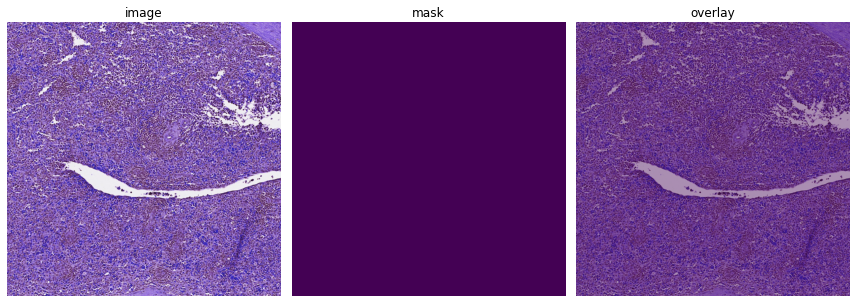

In [34]:
if debug:
    import matplotlib.pyplot as plt
    for img, mask in zip(imgs, pd_mks):
        plt.figure(figsize=(12, 7))
        plt.subplot(1, 3, 1); plt.imshow(img); plt.axis('OFF'); plt.title('image')
        plt.subplot(1, 3, 2); plt.imshow(mask); plt.axis('OFF'); plt.title('mask')
        plt.subplot(1, 3, 3); plt.imshow(img); plt.imshow(mask, alpha=0.4); plt.axis('OFF'); plt.title('overlay')
        plt.tight_layout()
        plt.show()

# Data check

In [16]:
import pandas as pd

In [19]:
train_csv = pd.read_csv('/content/train.csv')
df = pd.DataFrame(train_csv)

In [20]:
df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female
...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male


In [1]:
!gdown 1VnXyPKFiRL5Cvmw3UXLIK6Id93vjgKW5

Downloading...
From: https://drive.google.com/uc?id=1VnXyPKFiRL5Cvmw3UXLIK6Id93vjgKW5
To: /content/hubmap-organ-segmentation.zip
100% 6.20G/6.20G [00:55<00:00, 112MB/s]


In [ ]:
!unzip /content/hubmap-organ-segmentation.zip

In [4]:
!gdown 1787fZejOECLSAWpMg8fDwDgWSz6gTusT

Downloading...
From: https://drive.google.com/uc?id=1787fZejOECLSAWpMg8fDwDgWSz6gTusT
To: /content/Multi_256x256_MMSeg.zip
100% 316M/316M [00:04<00:00, 69.7MB/s]


In [ ]:
!unzip /content/Multi_256x256_MMSeg.zip

In [9]:
!gdown 1oUJ6Z8BkDt27CO4WYR-twaaYoSYAQxYb

Downloading...
From: https://drive.google.com/uc?id=1oUJ6Z8BkDt27CO4WYR-twaaYoSYAQxYb
To: /content/Binary_256x256_MMSeg.zip
100% 316M/316M [00:03<00:00, 94.3MB/s]


In [10]:
!unzip /content/Binary_256x256_MMSeg.zip -d /content/cut_binary_img

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/cut_binary_img/masks/164_0005.png  
  inflating: /content/cut_binary_img/masks/164_0006.png  
  inflating: /content/cut_binary_img/masks/164_0007.png  
  inflating: /content/cut_binary_img/masks/164_0008.png  
  inflating: /content/cut_binary_img/masks/16564_0001.png  
  inflating: /content/cut_binary_img/masks/16564_0002.png  
  inflating: /content/cut_binary_img/masks/16564_0003.png  
  inflating: /content/cut_binary_img/masks/16564_0004.png  
  inflating: /content/cut_binary_img/masks/16564_0005.png  
  inflating: /content/cut_binary_img/masks/16564_0007.png  
  inflating: /content/cut_binary_img/masks/16564_0008.png  
  inflating: /content/cut_binary_img/masks/16609_0000.png  
  inflating: /content/cut_binary_img/masks/16609_0001.png  
  inflating: /content/cut_binary_img/masks/16609_0002.png  
  inflating: /content/cut_binary_img/masks/16609_0003.png  
  inflating: /content/cut_binary_img/masks/16609_0004.png  
  inflating:

In [ ]:
import cv2
test_img = cv2.imread('train_images/orignal_image/10044.tiff')
test_img

In [12]:
cut_test_img = cv2.imread('/content/cut_img/masks/10392_0003.png')
cut_test_img.max()

4

In [13]:
cut_b_test_img = cv2.imread('/content/cut_binary_img/masks/10392_0003.png')
cut_b_test_img.max()

1